In [43]:
import glob
import numpy as np
import pandas as pd
import anndata as ad
import os.path as osp
from copy import deepcopy 
from datasets import load_dataset
from scipy.sparse import lil_matrix

import torch
from torch import nn
import torch.optim as optim
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

import umap
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

from train import train_model
from models.model_factory import model_factory, load_model
from utils import (
    get_genes_intersection, 
    plot_umaps, 
    get_evaluations, 
    plot_costs_matrix
)

In [3]:
def knockout_genes(adata, classes, top_marker_genes, genes_intersection):
    adata_knockout = adata.copy()
    genes2knockout = []
    for c in classes:
        genes2knockout += top_marker_genes[c].tolist()

    genes2knockout = get_genes_intersection(genes2knockout, genes_intersection)
    for gene in genes2knockout:
        gene_idx = adata_knockout.var_names.get_loc(gene)
        adata_knockout.X[:, gene_idx] = 0
    return adata_knockout

#### Organize and load dataset

In [4]:
# load dataset
ds = load_dataset(
    "helical-ai/yolksac_human",
    trust_remote_code=True, 
    split="train[:65%]",
    download_mode="reuse_cache_if_exists"
)
# organize data
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object") # non_zero values
lil.rows = np.array(ds['rows'],dtype="object") # indices of non zero values

# Update the AnnData object
adata = ad.AnnData(lil.tocsr(), obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
gene_name = adata.var_names.str.upper()
adata.var['gene_name'] = gene_name
# basic information
num_genes = len(adata.var['gene_name'])
num_cells = len(adata)

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1599.79 examples/s]


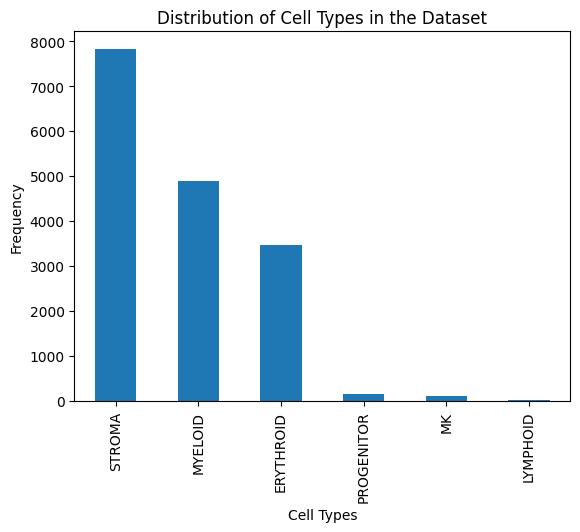

In [5]:
adata.obs['LVL1'].value_counts().plot(kind='bar')
plt.xlabel('Cell Types')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Types in the Dataset')
plt.show()

### Compute embeddings

In [7]:
# compute embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=128, device=device)
scgpt = scGPT(configurer = scgpt_config)
# data = scgpt.process_data(adata, gene_names = "gene_name")
# embeddings = scgpt.get_embeddings(data)
# np.save('embeddings/embeddings.npy', embeddings)
embeddings = np.load('embeddings/embeddings.npy')

INFO:helical.utils.downloader:File: 'C:\Users\nicof\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\nicof\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\nicof\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\nicof\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.


### Genes to knockout

To select the genes to knockout, the marker genes were identified using the Wilcoxon rank sum test to identify genes that are uniquely expressed in each cell type

In [16]:
# compute the genes intersection between the dataset and the model
genes_intersection = get_genes_intersection(adata.var_names, scgpt.vocab.keys())

genes a: 37318 genes b: 60697 intersection: 26517


In [15]:
normalized_adata = adata.copy()
sc.pp.normalize_total(normalized_adata, target_sum=1e4)
sc.pp.log1p(normalized_adata)

# Rank genes by their ability to differentiate cell types
sc.tl.rank_genes_groups(normalized_adata, groupby='LVL1', method='wilcoxon')

# Access the ranked genes
marker_genes = normalized_adata.uns['rank_genes_groups']['names']
np.save('markers/wilcoxon.npy', marker_genes)
# marker_genes = np.load('markers/wilcoxon.npy', allow_pickle=True)

Top Marker Genes: {'ERYTHROID': array(['HBG2', 'HBA1', 'HBZ', 'HBA2', 'HBE1', 'HBG1', 'PRDX2',
       'AC104389.5', 'HBM', 'SLC25A37', 'AHSP', 'ALAS2', 'GYPC', 'GYPB',
       'HMBS', 'FTH1', 'SLC4A1', 'FAM210B', 'SLC25A39', 'BLVRB',
       'SLC39A8', 'HBQ1', 'HEMGN', 'MTURN', 'KLF1', 'SELENBP1', 'FECH',
       'TMOD1', 'GYPE', 'ANK1', 'SMIM1', 'MYL4'], dtype=object), 'LYMPHOID': array(['DDIT4', 'IL2RG', 'RPS12', 'RAC2', 'LSP1', 'LCP1', 'DUSP2',
       'ZFP36L2', 'H2AFY', 'CD52', 'RPSA', 'RPS3', 'JCHAIN', 'NFKB1',
       'LMNB1', 'CTSW', 'NKG7', 'SEPTIN6', 'RPLP0', 'GAPDH', 'RPS4X',
       'PLP2', 'RPS2', 'EIF5A', 'CD7', 'TAGLN2', 'IFITM1', 'HSP90AA1',
       'CD69', 'DNMT1', 'NPM1', 'CD44'], dtype=object), 'MK': array(['TAGLN2', 'PF4', 'PPBP', 'NRGN', 'GP9', 'PRKAR2B', 'GP1BB',
       'MYL12A', 'MPIG6B', 'TUBA4A', 'RAP1B', 'H3F3A', 'CCL5', 'PDLIM1',
       'CMTM5', 'TUBB1', 'CLEC1B', 'GNG11', 'TMEM40', 'THBS1', 'TMSB4X',
       'CAVIN2', 'ITGA2B', 'LIMS1', 'FERMT3', 'TGFB1', 'ITGB3', '

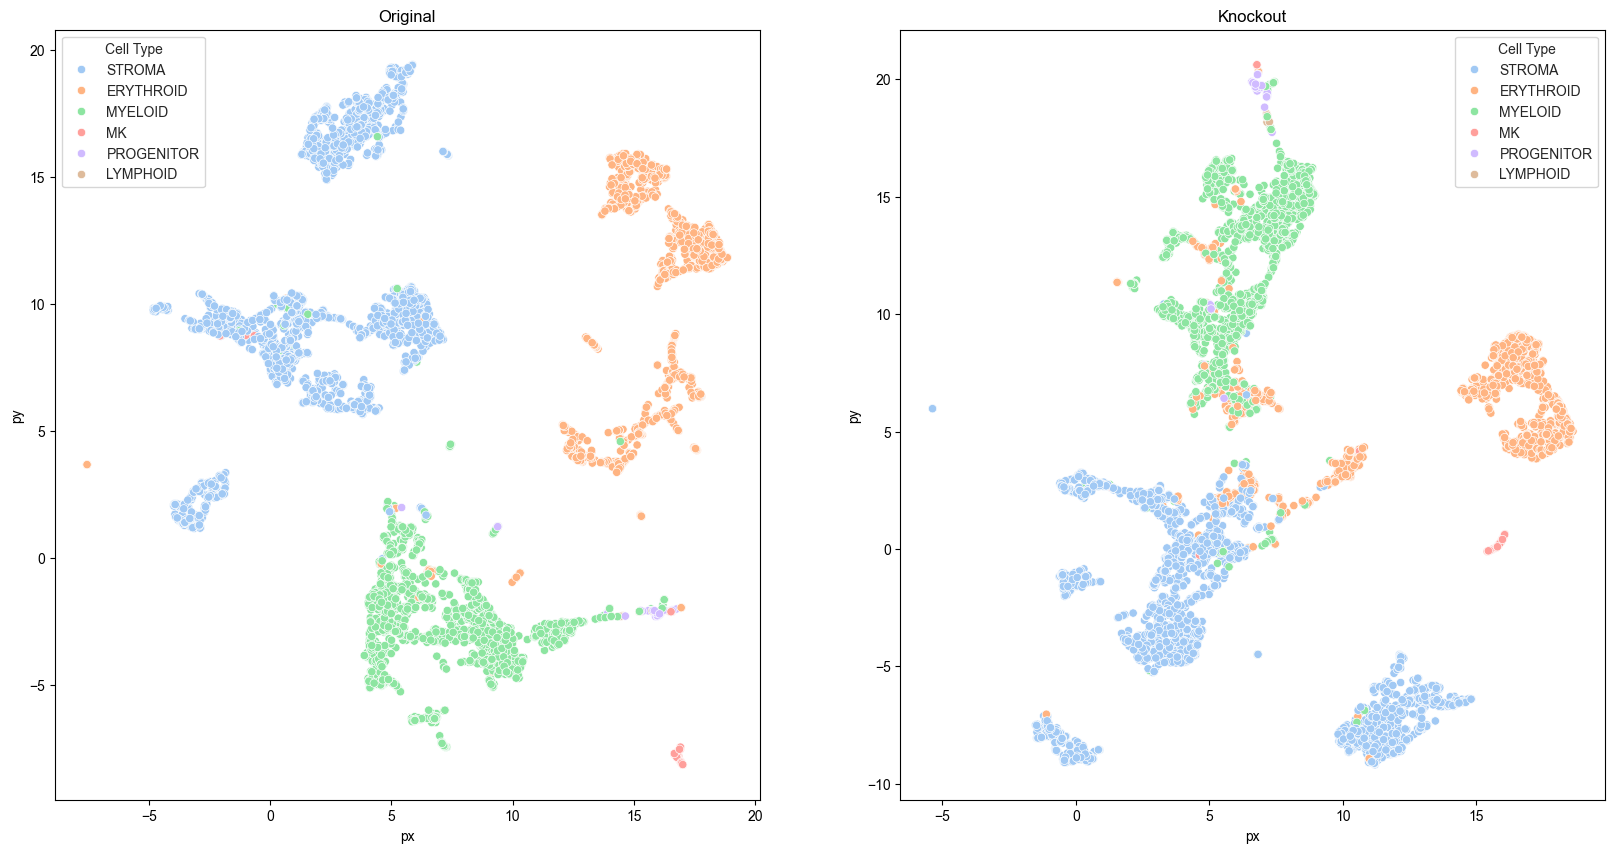

In [17]:
topk = 32
embeddings_name = f'embeddings/embeddings_knockout_top{topk}.npy'
list_embedding = glob.glob('embeddings/embeddings_knockout_top*')
list_embedding = [osp.basename(f) for f in list_embedding]
top_marker_genes = {cell_type: marker_genes[cell_type][:topk] for cell_type in marker_genes.dtype.names}
print("Top Marker Genes:", top_marker_genes)
classes = adata.obs['LVL1'].unique().tolist()
genes2knockout = []    
for c in classes:
    genes2knockout += top_marker_genes[c].tolist()
genes2knockout = list(set(genes2knockout)) # remove duplicates
print(f'removing {len(genes2knockout)} genes')
if osp.basename(embeddings_name) in list_embedding:
    knockout_embeddings = np.load(embeddings_name)
else:
    adata_knockout = knockout_genes(adata, classes, top_marker_genes, genes_intersection)
    # compute new embeddings
    data = scgpt.process_data(adata_knockout, gene_names = "gene_name")
    knockout_embeddings = scgpt.get_embeddings(data)
    np.save(embeddings_name, knockout_embeddings)
    knockout_embeddings = np.load(embeddings_name)

# compute UMAP
fig = plot_umaps([embeddings, knockout_embeddings], adata, limit=6000, granularity=1, titles=['Original', 'Knockout'])
# Compute pairwise cosine similarity
cos_sim_matrix = cosine_similarity(embeddings, knockout_embeddings)

# Compute the average cosine similarity across all samples
average_cosine_similarity = np.mean(np.diagonal(cos_sim_matrix))
print(f"Average Cosine Similarity: {average_cosine_similarity}")

In [ ]:
# save knockout genes
with open('knockout_genes.txt', 'w') as f:
    for gene in genes2knockout:
        f.write(f"{gene}\n")

### Split data and train model

In [9]:
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
num_types = adata.obs["LVL1"].unique().shape[0]
y = celltypes_labels
num_classes = num_types
classes = list(id2type.values())
y_labels = np.array([classes.index(c) for c in celltypes_labels]).reshape(-1, 1) 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

# split data not perturbed
indices = list(range(len(embeddings)))
# X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.1, random_state=42)
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42, stratify=y_encoded)
X_train, X_test, y_train, y_test = embeddings[train_indices], embeddings[test_indices], y_encoded[train_indices], y_encoded[test_indices]

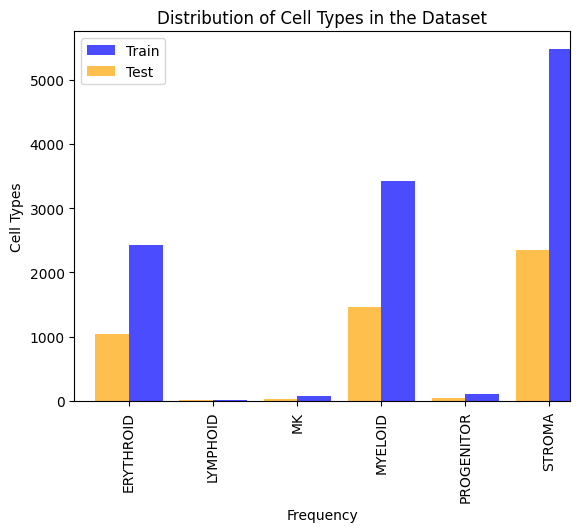

In [12]:
adata[train_indices].obs['LVL1'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7, label='Train', position=0, width=0.4)
adata[test_indices].obs['LVL1'].value_counts().sort_index().plot(kind='bar', color='orange', alpha=0.7, label='Test', position=1, width=0.4)

plt.xlabel('Frequency')
plt.ylabel('Cell Types')
plt.title('Distribution of Cell Types in the Dataset')
plt.legend()
plt.show()

### Data augmentation

There is an imbalance in the dataset. The biological relevance of data augmentation is a topic for discussion, but for now, I will leave this for further experimentation.

In [28]:
# data augmentation
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data
smote = SMOTE(sampling_strategy='not majority', random_state=42)

X_train_ads = adata[train_indices].X.toarray()
y_train_np = y_train.numpy()  # Convert y_train to numpy array
X_train_augmented, y_train_augmented = smote.fit_resample(X_train_ads, y_train_np)
print(f"Original Training Size: {X_train_ads.shape}")
print(f"Augmented Training Size: {X_train_augmented.shape}")

(512,)

In [41]:
embeddings.min(), embeddings.max()

(-0.57484066, 0.54931384)

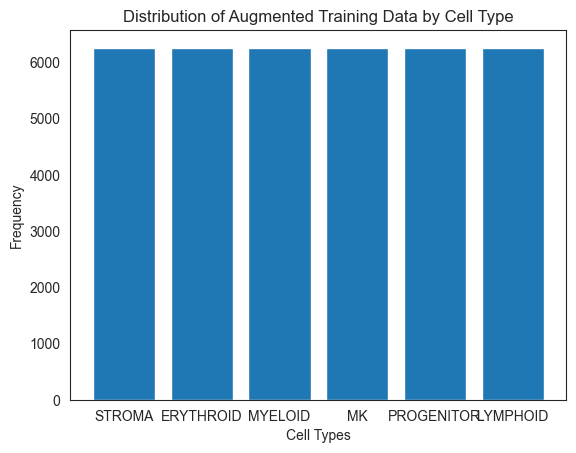

In [37]:
y_train_augmented
# Plot histogram by class
class_counts = np.sum(y_train_augmented, axis=0)
plt.bar(classes, class_counts)
plt.xlabel('Cell Types')
plt.ylabel('Frequency')
plt.title('Distribution of Augmented Training Data by Cell Type')
plt.show()

### Train models

Train multiple models to perform a statistical test and confirm whether the knockout genes have statistical significance in the results

Epoch 1, Validation Loss: 0.08134557213634253
Epoch 11, Validation Loss: 0.041962023196109116
Epoch 21, Validation Loss: 0.04358588742504183
Epoch 31, Validation Loss: 0.037730293634992376
Epoch 41, Validation Loss: 0.04309594163742776


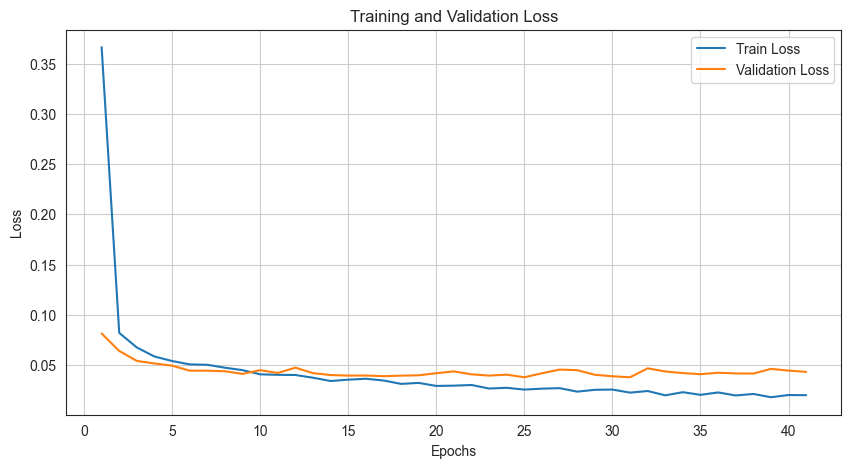

Epoch 1, Validation Loss: 0.0825791846638402
Epoch 11, Validation Loss: 0.04086329631704407
Epoch 21, Validation Loss: 0.04089227327159069
Epoch 31, Validation Loss: 0.04240469525542815
Epoch 41, Validation Loss: 0.04544170901424831


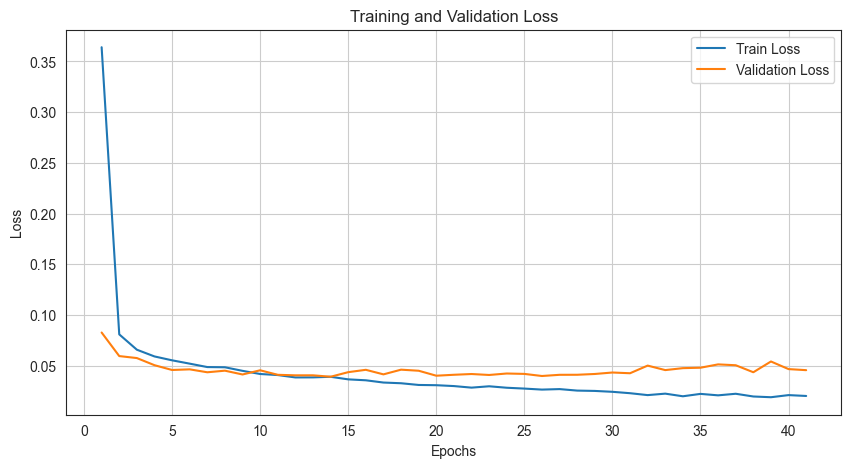

Epoch 1, Validation Loss: 0.08263729706120032
Epoch 11, Validation Loss: 0.046711564068503394
Epoch 21, Validation Loss: 0.04156024921954108
Epoch 31, Validation Loss: 0.04281014209510221
Epoch 41, Validation Loss: 0.04344605778355916


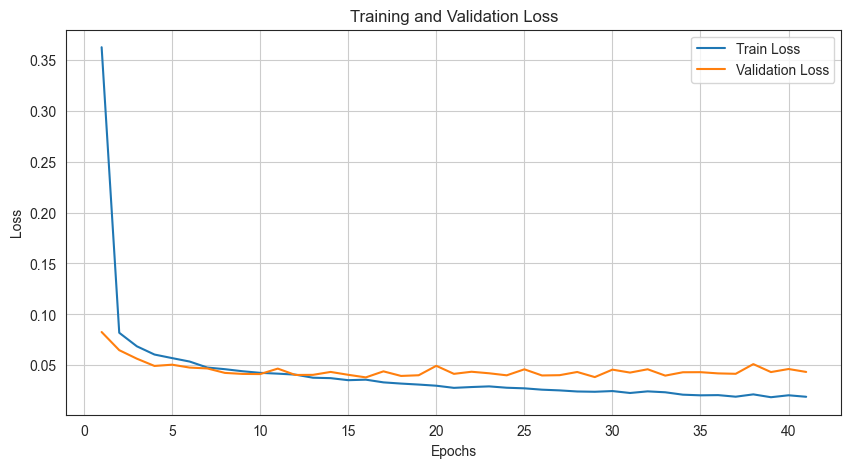

Epoch 1, Validation Loss: 0.0841684541426217
Epoch 11, Validation Loss: 0.041817709403590135
Epoch 21, Validation Loss: 0.03909136547232405
Epoch 31, Validation Loss: 0.04626981745110616
Epoch 41, Validation Loss: 0.04186614927946208


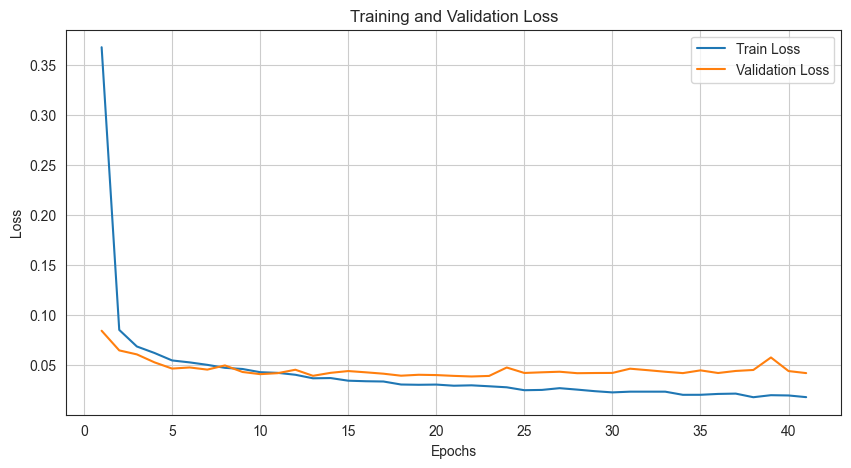

In [82]:
model_type = 'simple_model_v2'
weights_dir = f'weights/{model_type}'
num_epochs = 41
for i in range(4):
    model = model_factory(model_type, num_types, 512)
    model = train_model(model, 
                        torch.from_numpy(X_train), 
                        y_train, 
                        torch.from_numpy(X_test), 
                        y_test,
                        optim.Adam(model.parameters(), lr=0.001),
                        nn.CrossEntropyLoss(),
                        num_epochs=num_epochs,
                        weights_dir=weights_dir)

### Compute performance metrics in test set and asses statistical significance

In [42]:
# use the same indices for the perturbed data
X_trainp, X_testp, y_trainp, y_testp = knockout_embeddings[train_indices], knockout_embeddings[test_indices], y_encoded[train_indices], y_encoded[test_indices]

In [108]:
list_models = glob.glob(f'{weights_dir}/modelv*')
metrics = pd.DataFrame()
y_pred_knockouts = []
y_preds = []
for model_path in list_models:
    # load model
    model = load_model(model_type, num_types, model_path)

    # original embeddings
    predictions_nn = model(torch.Tensor(X_test))
    y_pred = np.array(torch.argmax(predictions_nn, dim=1))
    y_preds.append(y_pred)
    y_true = np.array(y_test.argmax(axis=1))
    original_metrics = get_evaluations("Test set", y_true, y_pred)
    original_metrics['embeddings'] = 'original'
    original_metrics['model'] = f'{osp.basename(model_path)}'
    original_metrics = pd.DataFrame(original_metrics, index=[0])

    # knockout embeddings
    predictions_nn = model(torch.Tensor(X_testp))
    y_pred_knockout = np.array(torch.argmax(predictions_nn, dim=1))
    y_pred_knockouts.append(y_pred_knockout)
    y_true = np.array(y_testp.argmax(axis=1))
    knockout_metrics = get_evaluations("Test set", y_true, y_pred_knockout)
    knockout_metrics['embeddings'] = 'knockout'
    knockout_metrics['model'] = f'{osp.basename(model_path)}'
    knockout_metrics = pd.DataFrame(knockout_metrics, index=[0])
   
    # concat 
    metrics = pd.concat([metrics, original_metrics, knockout_metrics], ignore_index=True)

# Select relevant columns
metrics = metrics[['embeddings','model', 'accuracy', 'precision', 'f1', 'recall']]
metrics

Test set accuracy: 98.9%
Test set precision: 88.1%
Test set f1: 88.8%
Test set recall: 89.6%
Test set accuracy: 94.5%
Test set precision: 78.4%
Test set f1: 81.1%
Test set recall: 85.7%
Test set accuracy: 98.6%
Test set precision: 89.0%
Test set f1: 89.2%
Test set recall: 89.5%
Test set accuracy: 94.1%
Test set precision: 77.0%
Test set f1: 80.4%
Test set recall: 86.4%
Test set accuracy: 98.9%
Test set precision: 88.0%
Test set f1: 88.0%
Test set recall: 88.2%
Test set accuracy: 93.8%
Test set precision: 75.4%
Test set f1: 78.5%
Test set recall: 85.2%
Test set accuracy: 98.9%
Test set precision: 89.9%
Test set f1: 89.8%
Test set recall: 89.6%
Test set accuracy: 94.3%
Test set precision: 78.0%
Test set f1: 80.5%
Test set recall: 85.0%
Test set accuracy: 98.5%
Test set precision: 87.6%
Test set f1: 88.2%
Test set recall: 88.8%
Test set accuracy: 94.1%
Test set precision: 77.3%
Test set f1: 80.5%
Test set recall: 85.8%


,embeddings,model,accuracy,precision,f1,recall
0,original,modelv0.pth,0.988671,0.881399,0.887728,0.896150
1,knockout,modelv0.pth,0.944568,0.783695,0.810850,0.856951
2,original,modelv1.pth,0.985636,0.890273,0.892350,0.895345
3,knockout,modelv1.pth,0.941331,0.770348,0.804182,0.863719
4,original,modelv2.pth,0.989075,0.879719,0.880213,0.881519
5,knockout,modelv2.pth,0.937892,0.753915,0.785189,0.852184
6,original,modelv3.pth,0.989278,0.899190,0.897516,0.895967
7,knockout,modelv3.pth,0.942950,0.779728,0.804680,0.849855
8,original,modelv4.pth,0.985434,0.875884,0.881534,0.887717
9,knockout,modelv4.pth,0.941331,0.772774,0.804518,0.858209


In [97]:
# Perform paired t-test
original_accuracies = metrics[metrics['embeddings'] == 'original']['accuracy']
knockout_accuracies = metrics[metrics['embeddings'] == 'knockout']['accuracy']
t_stat, p_value = ttest_rel(original_accuracies, knockout_accuracies)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

if p_value < 0.05:
    print("The knockouts have a statistically significant impact on classification.")
else:
    print("No statistically significant impact detected.")


T-Statistic: 38.187488316978815, P-Value: 2.808562309070481e-06
The knockouts have a statistically significant impact on classification.


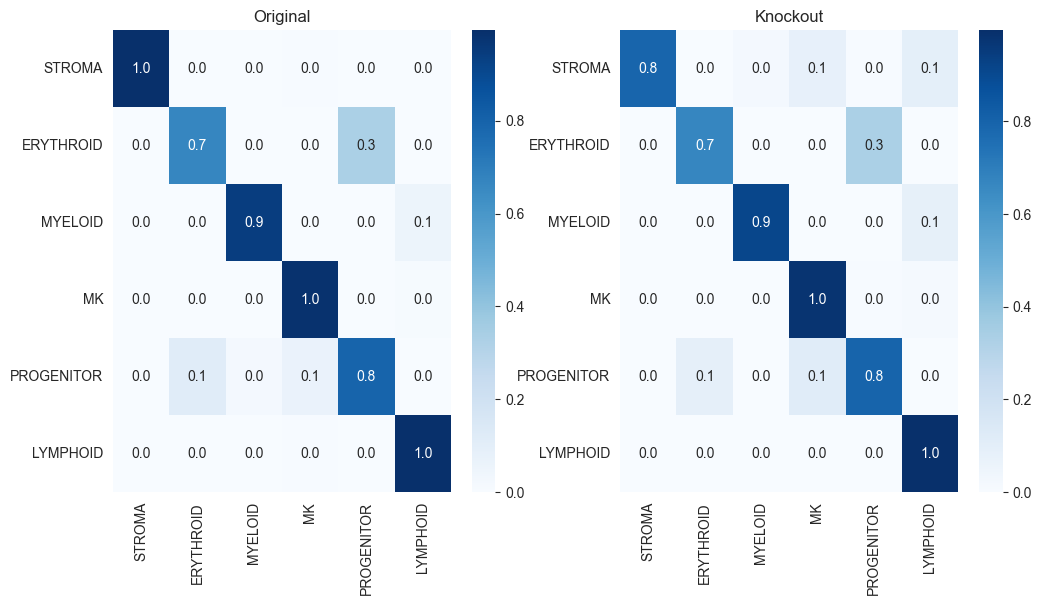

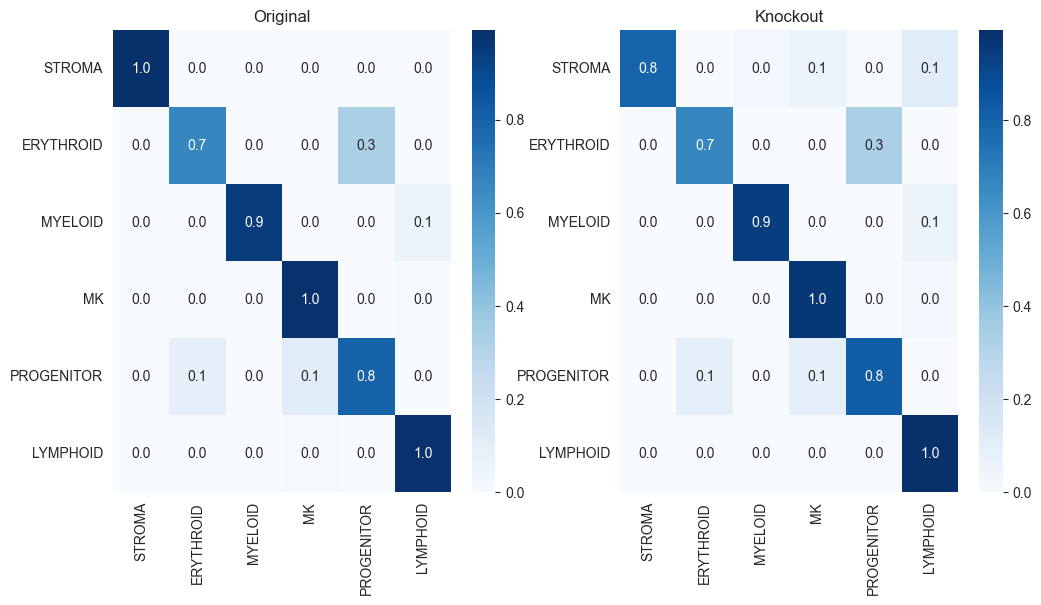

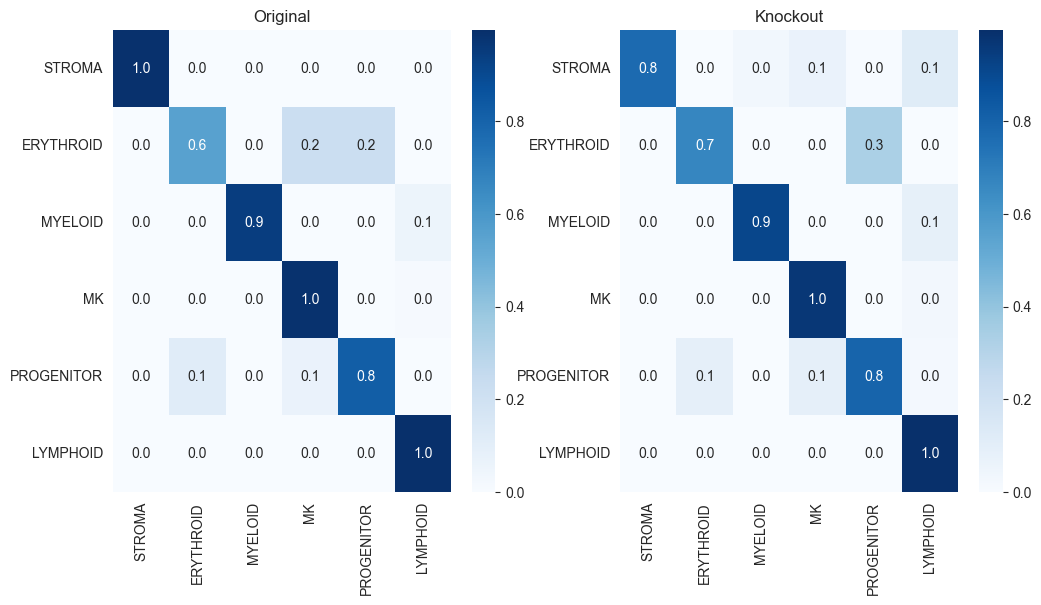

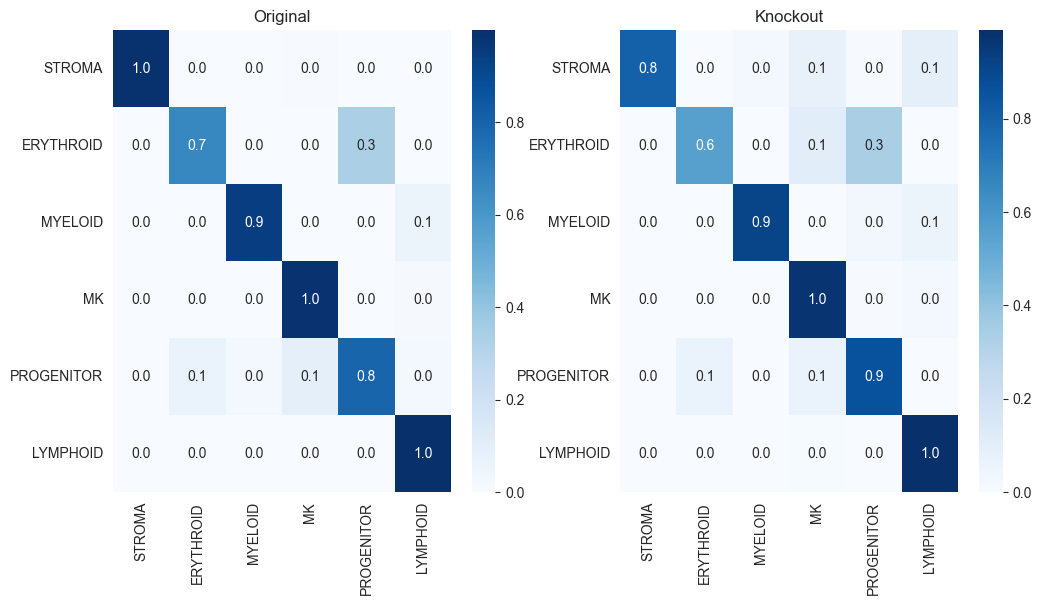

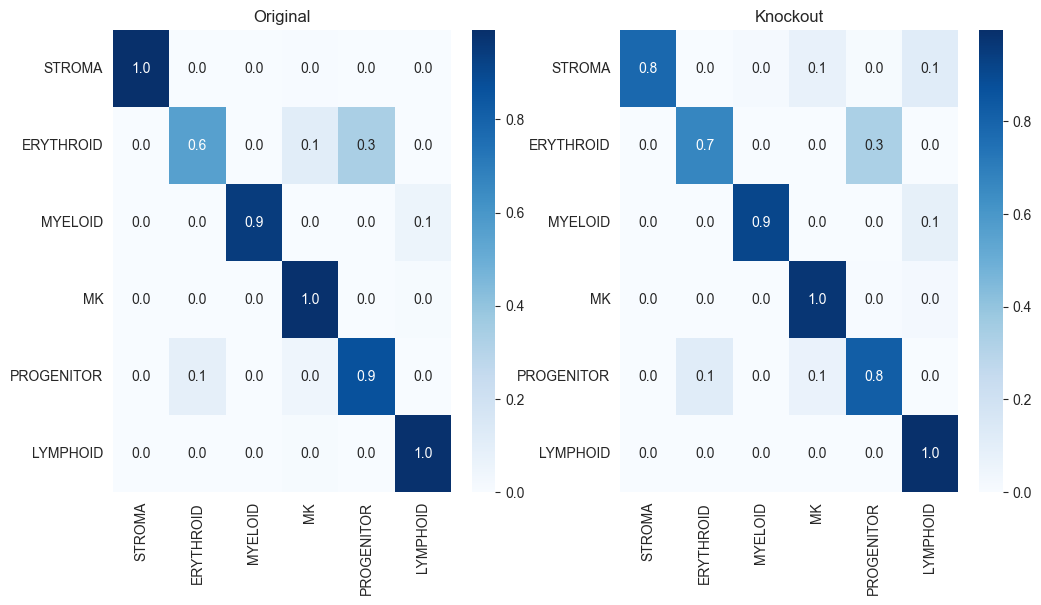

In [111]:
for y_pred, y_pred_knockout in zip(y_preds, y_pred_knockouts):
    ys = [y_pred, y_pred_knockout]
    plot_costs_matrix(y_true, ys, classes)

### Cross validation

In [ ]:
model_type = 'simple_model_v2'
# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the metrics dataframe
metrics = pd.DataFrame()

# Perform cross-validation
for fold, (train_indices, test_indices) in enumerate(skf.split(embeddings, y_encoded.argmax(axis=1))):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Split data
    X_train, X_test = embeddings[train_indices], embeddings[test_indices]
    y_train, y_test = y_encoded[train_indices], y_encoded[test_indices]
    X_trainp, X_testp = knockout_embeddings[train_indices], knockout_embeddings[test_indices]
    y_trainp, y_testp = y_encoded[train_indices], y_encoded[test_indices]
    
    # Load model
    model_path = 'weights/simple_model_v2/modelv0.pth'
    model = load_model(model_type, num_types, model_path)
    
    # Evaluate original embeddings
    predictions_nn = model(torch.Tensor(X_test))
    y_pred = np.array(torch.argmax(predictions_nn, dim=1))
    y_true = np.array(y_test.argmax(axis=1))
    original_metrics = get_evaluations("Test set", y_true, y_pred)
    original_metrics['embeddings'] = 'original'
    original_metrics['model'] = f'{osp.basename(model_path)}'
    original_metrics['fold'] = fold + 1
    original_metrics = pd.DataFrame(original_metrics, index=[0])
    
    # Evaluate knockout embeddings
    predictions_nn = model(torch.Tensor(X_testp))
    y_pred_knockout = np.array(torch.argmax(predictions_nn, dim=1))
    y_true = np.array(y_testp.argmax(axis=1))
    knockout_metrics = get_evaluations("Test set", y_true, y_pred_knockout)
    knockout_metrics['embeddings'] = 'knockout'
    knockout_metrics['model'] = f'{osp.basename(model_path)}'
    knockout_metrics['fold'] = fold + 1
    knockout_metrics = pd.DataFrame(knockout_metrics, index=[0])
    
    # Concatenate metrics
    metrics = pd.concat([metrics, original_metrics, knockout_metrics], ignore_index=True)

# Select relevant columns
metrics = metrics[['fold', 'embeddings', 'model', 'accuracy', 'precision', 'f1', 'recall']]
metrics

Fold 1/5
Test set accuracy: 99.5%
Test set precision: 98.0%
Test set f1: 96.4%
Test set recall: 95.2%
Test set accuracy: 94.8%
Test set precision: 88.2%
Test set f1: 88.3%
Test set recall: 89.6%
Fold 2/5
Test set accuracy: 99.4%
Test set precision: 98.5%
Test set f1: 96.5%
Test set recall: 94.7%
Test set accuracy: 95.5%
Test set precision: 86.7%
Test set f1: 87.8%
Test set recall: 90.0%
Fold 3/5
Test set accuracy: 98.8%
Test set precision: 94.9%
Test set f1: 92.8%
Test set recall: 91.0%
Test set accuracy: 94.8%
Test set precision: 91.5%
Test set f1: 91.1%
Test set recall: 91.6%
Fold 4/5
Test set accuracy: 99.2%
Test set precision: 93.0%
Test set f1: 94.0%
Test set recall: 95.1%
Test set accuracy: 94.9%
Test set precision: 84.4%
Test set f1: 83.6%
Test set recall: 85.0%
Fold 5/5
Test set accuracy: 99.3%
Test set precision: 90.0%
Test set f1: 90.8%
Test set recall: 92.4%
Test set accuracy: 94.8%
Test set precision: 78.6%
Test set f1: 81.2%
Test set recall: 85.3%


,fold,embeddings,model,accuracy,precision,f1,recall
0,1,original,modelv0.pth,0.995144,0.979534,0.964463,0.951918
1,1,knockout,modelv0.pth,0.948103,0.881843,0.882907,0.895878
2,2,original,modelv0.pth,0.994234,0.985036,0.964562,0.947010
3,2,knockout,modelv0.pth,0.954780,0.867196,0.877884,0.899912
4,3,original,modelv0.pth,0.988467,0.948953,0.928285,0.910175
5,3,knockout,modelv0.pth,0.947800,0.914998,0.911100,0.916313
6,4,original,modelv0.pth,0.991502,0.930460,0.939817,0.950721
7,4,knockout,modelv0.pth,0.948710,0.844454,0.836405,0.850064
8,5,original,modelv0.pth,0.992714,0.899906,0.908381,0.923993
9,5,knockout,modelv0.pth,0.948087,0.786093,0.811720,0.852936


In [22]:
# Perform paired t-test
original_accuracies = metrics[metrics['embeddings'] == 'original']['accuracy']
knockout_accuracies = metrics[metrics['embeddings'] == 'knockout']['accuracy']
t_stat, p_value = ttest_rel(original_accuracies, knockout_accuracies)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

if p_value < 0.05:
    print("The knockouts have a statistically significant impact on classification.")
else:
    print("No statistically significant impact detected.")


T-Statistic: 31.55296247159718, P-Value: 6.012957686262706e-06
The knockouts have a statistically significant impact on classification.
